In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, InputLayer, Flatten, MaxPool2D, RandomZoom, RandomRotation, RandomFlip, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "Dataset/Training",
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    color_mode="grayscale",
    batch_size=32,
    shuffle=True
    )

test_dataset = tf.keras.utils.image_dataset_from_directory(
    "Dataset/Testing",
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    color_mode="grayscale",
    batch_size=32,
    shuffle=False
    )

for images, labels in train_dataset.take(1):
    print(f"Images batch shape: {images.shape}")
    print(f"Labels batch shape: {labels.shape}")
    print(f"First 5 labels: {labels[:5].numpy()}")

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Images batch shape: (32, 224, 224, 1)
Labels batch shape: (32,)
First 5 labels: [0 0 1 2 2]


In [3]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label

train_dataset = train_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

In [4]:
data_augmentation = tf.keras.Sequential([
    RandomFlip(mode="horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

train_dataset = train_dataset.map(lambda image, label: (data_augmentation(image), label))
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [7]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(224, 224, 1)),
    
    Conv2D(filters=3, kernel_size=3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    Conv2D(filters=6, kernel_size=3, activation="relu", name="last_conv_layer"),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    Flatten(),
    
    Dense(units=64, activation="relu"),
    Dense(units=4, activation="softmax")
])

model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 3)       30        
                                                                 
 batch_normalization_2 (Batc  (None, 222, 222, 3)      12        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 3)      0         
 2D)                                                             
                                                                 
 last_conv_layer (Conv2D)    (None, 109, 109, 6)       168       
                                                                 
 batch_normalization_3 (Batc  (None, 109, 109, 6)      24        
 hNormalization)                                                 
                                                      

In [8]:
model.fit(train_dataset, epochs=50, verbose=1)

Epoch 1/50
179/179 [==============================] - 14s 74ms/step - loss: 0.9949 - accuracy: 0.6562
Epoch 2/50
179/179 [==============================] - 12s 65ms/step - loss: 0.6118 - accuracy: 0.7645
Epoch 3/50
179/179 [==============================] - 11s 63ms/step - loss: 0.5574 - accuracy: 0.7869
Epoch 4/50
179/179 [==============================] - 11s 61ms/step - loss: 0.4945 - accuracy: 0.8039
Epoch 5/50
179/179 [==============================] - 12s 63ms/step - loss: 0.4707 - accuracy: 0.8165
Epoch 6/50
179/179 [==============================] - 11s 63ms/step - loss: 0.4374 - accuracy: 0.8344
Epoch 7/50
179/179 [==============================] - 12s 63ms/step - loss: 0.4280 - accuracy: 0.8419
Epoch 8/50
179/179 [==============================] - 11s 63ms/step - loss: 0.3946 - accuracy: 0.8531
Epoch 9/50
179/179 [==============================] - 13s 73ms/step - loss: 0.3714 - accuracy: 0.8605
Epoch 10/50
179/179 [==============================] - 13s 70ms/step - loss: 0.390

In [9]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


41/41 [==============================] - 6s 138ms/step - loss: 1.1796 - accuracy: 0.7063
Test Loss: 1.179591417312622
Test Accuracy: 0.7063310742378235


1/1 [==============================] - 0s 69ms/step


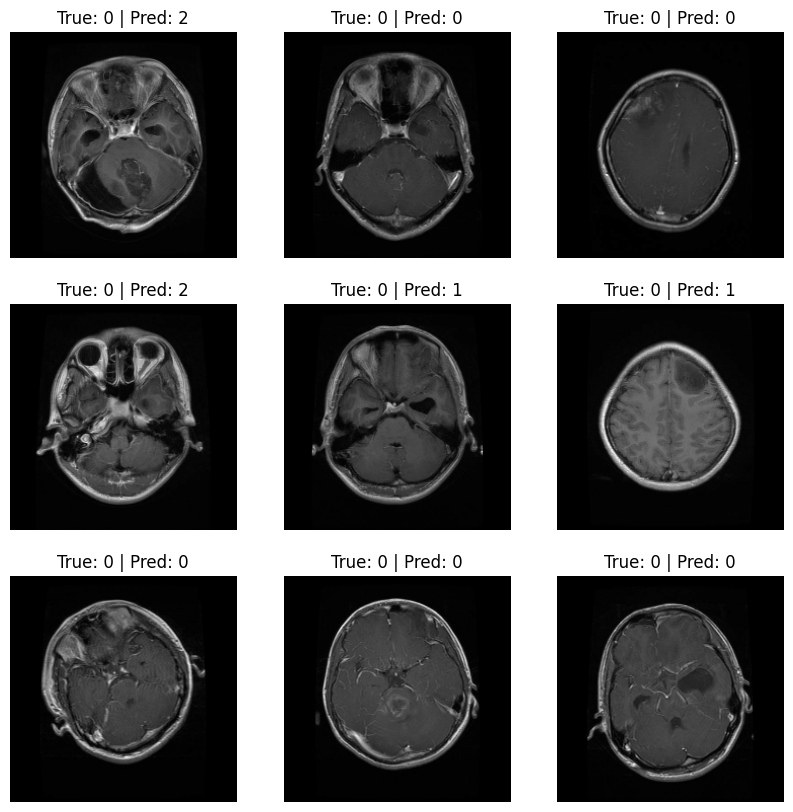

In [11]:
for images, true_labels in test_dataset.take(1):
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f"True: {true_labels[i].numpy()} | Pred: {predicted_classes[i]}")
        plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 134ms/step
Recall:  0.7063310450038138
Precision:  0.7596590825532545
F1 score:  0.6940920290916907


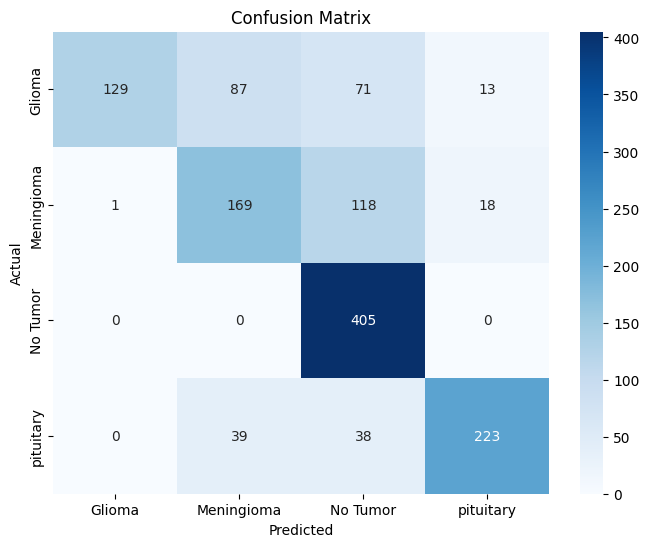

41/41 [==============================] - 1s 18ms/step
AUC-ROC Scores for each class:
Class Glioma: 0.9572
Class Meningioma: 0.8251
Class No Tumor: 0.9794
Class pituitary: 0.9649
Average AUC-ROC: 0.9316


In [10]:
y_true = []
y_pred = []

class_names = ["Glioma", "Meningioma", "No Tumor", "pituitary"]

# Loop through the test dataset to get true labels and predictions
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(images).argmax(axis=-1))

# Convert the lists into numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 1. Precision, Recall, F1 Score
print("Recall: ",recall_score(y_true, y_pred, average="weighted"))
print("Precision: ",precision_score(y_true, y_pred, average="weighted"))
print("F1 score: ",f1_score(y_true, y_pred, average="weighted"))

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# 3. AUC-ROC (Assuming multi-class classification)
# Compute the AUC for each class
y_pred_prob = model.predict(test_dataset)  # Predicted probabilities for each class
auc_scores = []

# Loop over each class and compute AUC score
for i in range(y_pred_prob.shape[1]):
    auc_score = roc_auc_score(y_true == i, y_pred_prob[:, i])
    auc_scores.append(auc_score)

print("AUC-ROC Scores for each class:")
for i, auc_score in enumerate(auc_scores):
    print(f"Class {class_names[i]}: {auc_score:.4f}")

# Average AUC across all classes (macro average)
average_auc = np.mean(auc_scores)
print(f"Average AUC-ROC: {average_auc:.4f}")

In [22]:
# Save the model to a file (in HDF5 format)
model.save('model/64-4.h5')



In [1]:
# ------------------- Load The Model -------------------

from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('model/50-10-4.h5')

# Verify by checking the model summary
loaded_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 3)       30        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 3)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 6)       168       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 6)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 17496)             0         
                                                                 
 dense_3 (Dense)             (None, 50)               

In [ ]:
loaded_model.predict()